In [1]:
# Descargar desde https://www.lfd.uci.edu/~gohlke/pythonlibs/#opencv
# opencv_python-3.4.6+contrib-cp36-cp36m-win_amd64.whl
# opencv_python-3.4.6+contrib-cp36-cp36m-win32.whl
# pip install "<Dir>/opencv_python-3.4.6+contrib-cp36-cp36m-win_amd64.whl"
# <Dir> = donde esta guardado el archivo .whl

# Install packages:
# pip install Pillow numpy

In [2]:
from PIL import Image
import numpy as np
#import sys
import colorsys
import cv2   # OpenCV: Open Computer Vision
import math as mt
from matplotlib import pyplot as plt    # Plotting

## Transformations ##

In [3]:
#Matrix Multiplication Block (Common for all operations, just varying matrix)
def getImageArray(respectiveArray, editablePhoto, sizeY, sizeX):
    for i in range(sizeY):
        for j in range(sizeX):
            currMatrix = np.array((0,0,0), dtype= 'float')
            for k in range(3):
                currMatrix[k]=editablePhoto[i,j,k]
            lmsImage = np.dot(respectiveArray,currMatrix)
            for k in range(3):
                editablePhoto[i,j,k]=lmsImage[k]
    return editablePhoto


#Converting Processed Array to Image
def arrayToImage(editablePhoto,sizeY,sizeX):
    rgbArray = np.zeros((sizeY,sizeX,3),dtype = 'uint8')
    for i in range(sizeY):
        for j in range(sizeX):
            for k in range(3):
                rgbArray[i,j,k] = round(editablePhoto[i,j,k], 0)
    return rgbArray

## Colour Scale Converting

In [4]:
# Converting RGB to LMS
def RGBToLMS(img, sizeY, sizeX):
    Photo = np.zeros((sizeY,sizeX,3), dtype = 'float')
    for i in range(sizeY):
        for j in range(sizeX):
            for k in range(3):
                Photo[i,j,k] = img[i,j,k] / 255

    LMSConvert = np.array([[17.8824,43.5161,4.11935],[3.45565,27.1554,3.86714],[0.0299566,0.184309,1.46709]])
    Photo = getImageArray(LMSConvert, Photo, sizeY, sizeX)

    return Photo


# Converting LMS to RGB
def LMSToRGB(img,sizeY,sizeX):
    LMSConvert = np.array([[17.8824,43.5161,4.11935],[3.45565,27.1554,3.86714],[0.0299566,0.184309,1.46709]])
    RGBConvert = np.linalg.inv(LMSConvert)
    Photo = getImageArray(RGBConvert, img, sizeY, sizeX)
    for i in range(sizeY):
        for j in range(sizeX):
            for k in range(3):
                Photo[i,j,k] = Photo[i,j,k] * 255
    return Photo

In [5]:
# Converting RGB to HSV
def RGBToHSV(img, sizeY, sizeX):
    HSV = np.zeros((sizeY,sizeX,3), dtype = 'float')
    for i in range(sizeY):
        for j in range(sizeX):
            rNew = img[i,j,0] / 255
            gNew = img[i,j,1] / 255
            bNew = img[i,j,2] / 255
            for k in range(0,3):
                HSV[i,j,k] = colorsys.rgb_to_hsv(rNew,gNew,bNew)[k]
    return HSV


# Converting HSV to RGB
def HSVToRGB(img, sizeY, sizeX):
    RGB = np.zeros((sizeY,sizeX,3), dtype = 'uint8')
    nans = np.isnan(img)
    img[nans] = 0
    for i in range(sizeY):
        for j in range(sizeX):
            for k in range(0,3):
                RGB[i][j][k] = round(colorsys.hsv_to_rgb(img[i][j][0],img[i][j][1],img[i][j][2])[k] * 255, 0)
    return RGB

## Luminosity ##

In [6]:
def Luminosity(img, Lums):
    HSV = RGBToHSV(img, img.shape[0], img.shape[1])

    for i in range(HSV.shape[0]):
        for j in range(HSV.shape[1]):
            Value = (HSV[i][j][2] * (1 + Lums/100))
            HSV[i][j][2] = max(Value if Value < 1 else 1, 0)

    RGB = HSVToRGB(HSV, HSV.shape[0], HSV.shape[1])
    return RGB

## Simulating Colourblindness ##

In [7]:
#Simulating Protanopia
def ConvertToProtanopes(img,sizeY,sizeX):
    ProtanopeConvert = np.array([[0,2.02344,-2.52581],[0,1,0],[0,0,1]])
    Photo = getImageArray(ProtanopeConvert, img, sizeY, sizeX)
    return Photo

#Simulating Deutranopia
def ConvertToDeuteranopes(img,sizeY,sizeX):
    DeuteranopesConvert = np.array([[1,0,0],[0.494207,0,1.24827],[0,0,1]])
    Photo = getImageArray(DeuteranopesConvert, img, sizeY, sizeX)
    return Photo

#Simulating Tritanopia
def ConvertToTritanopes(editablePhoto,sizeY,sizeX):
    TritanopeConvert = np.array([[1,0,0],[0,1,0],[-0.395913,0.801109,0]])
    Photo = getImageArray(TritanopeConvert, img, sizeY, sizeX)
    return Photo

## Colourblind Corrections ##

In [8]:
#Correcting the image using HSV Shifting Algorithm (red-green)
def Correct(Img, sizeY,sizeX):
    Cor = np.zeros((sizeY,sizeX,3),dtype = 'float')
    Cor = Img.copy()
    HSV = np.zeros((sizeY,sizeX,3),dtype = 'float')
    HSV = RGBToHSV(Img,sizeY,sizeX)

    for i in range(sizeY):
        for j in range(sizeX):
            rNew = float(Cor[i,j,0] / 255)
            gNew = float(Cor[i,j,1] / 255)
            bNew = float(Cor[i,j,2] / 255)

            if gNew > 0:
                greenRatio = (HSV[i,j,0] - (60/360))/gNew
                blueRange = greenRatio*bNew
                HSV[i][j][0] = 0.5 + blueRange
            else:
                tempArray = np.zeros((3),'float')
                tempArray[0] = np.nan_to_num(np.inf)
                tempArray[1] = greenRatio*bNew
                tempArray[2] = 0.5 + blueRange
                np.nan_to_num(tempArray)
                tempArray[np.isneginf(tempArray)] = 0
                tempArray[np.isinf(tempArray)] = 1
                HSV[i][j][0] = tempArray[2]

    Photo = HSVToRGB(HSV,sizeY,sizeX)

    Correct = arrayToImage(Photo,sizeY,sizeX)
    return Correct

## Functions ##

In [9]:
# Compare 3 images side by side
def Compare(Size, img1, img2, img3, img4, img5, img6, img7, img8):
    sz = Size
    fig = plt.figure(figsize=(sz,sz))

    # Fila 1
    fig.add_subplot(241)
    plt.axis('off'), plt.title('Original')
    plt.imshow(img1)

    fig.add_subplot(242)
    plt.axis('off'), plt.title('Simulada')
    plt.imshow(img2)

    fig.add_subplot(243)
    plt.axis('off'), plt.title('Corregida')
    plt.imshow(img3)

    fig.add_subplot(244)
    plt.axis('off'), plt.title('Sim. Cor.')
    plt.imshow(img4)

    # Fila 2
    fig.add_subplot(245)
    plt.axis('off'), plt.title('Iluminada')
    plt.imshow(img5)

    fig.add_subplot(246)
    plt.axis('off'), plt.title('Sim. Ilu.')
    plt.imshow(img6)

    fig.add_subplot(247)
    plt.axis('off'), plt.title('Cor. Ilu')
    plt.imshow(img7)

    fig.add_subplot(248)
    plt.axis('off'), plt.title('Sim. Cor. Ilu.')
    plt.imshow(img8)

    plt.show()
    return


#Main function decides which function to call based on user choice in ArgParse
def Corrections(img, corType):
    sizeY = img.shape[0]
    sizeX = img.shape[1]
    corPhoto = Correct(img,sizeY,sizeX)
    return corPhoto


#Main function decides which function to call based on user choice in ArgParse
def Simulations(img, simType):
    sizeY = img.shape[0]
    sizeX = img.shape[1]
    LMS = RGBToLMS(img,sizeY,sizeX)

    if simType == 1:
        simPhoto = ConvertToProtanopes(LMS,sizeY,sizeX)
    if simType == 2:
        simPhoto = ConvertToDeuteranopes(LMS,sizeY,sizeX)
    if simType == 3:
        simPhoto = ConvertToTritanopes(LMS,sizeY,sizeX)

    RGB = LMSToRGB(simPhoto,sizeY,sizeX)
    Img = arrayToImage(RGB,sizeY,sizeX)
    return Img

## Inputs ##

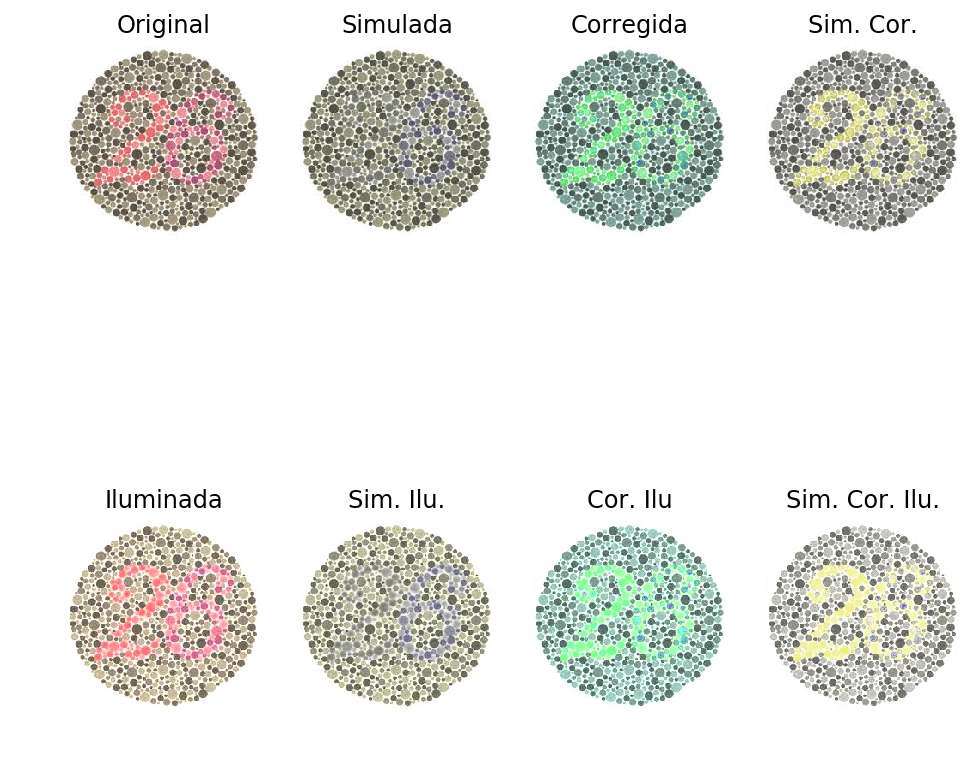

In [10]:
# Input Image
img  = cv2.imread('deut.jpg')                 # Imagen Original en BGR
#img = cv2.imread('rubiko.jpg')
#img = cv2.imread('rubik.png')
#img = cv2.imread('Chromia.jpg')

Ori  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Blue-Green-Red -> Red-Green-Blue
Size = 8

# Varianza en la Iluminacion (L %) (+ o -)
L = 25

# simType = Prot / Deut / Trit (1 / 2 / 3)
simType = 1

# Trit necesita retoques
# (no está efectuando bien la simulacion)

# corType
corType = simType

# Output Image
if 0 < simType < 4:
    Sim = Simulations(Ori,simType)
    Cor = Corrections(Ori,corType)
    CBC = Simulations(Cor,simType)

    Lum = Luminosity(Ori, L)
    SLu = Simulations(Lum,simType)
    CLu = Corrections(Lum,simType)
    SCL = Simulations(CLu,simType)
    Compare(Size, Ori, Sim, Cor, CBC, Lum, SLu, CLu, SCL) # Plotting Images
    
    cv2.imwrite('Corregida.jpg', Cor)
    cv2.imwrite('Simulada.jpg', Sim)
else:
    print("Error: elegir tipo de daltonismo (1 - 3)")